In [10]:
# 1. 最もシンプルな推論（Jupyter用）
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# モデルをロード（最新のモデルパスを指定）
model_path = "runs/segment/learning_time_5h/weights/best.pt"  # 実際のパスに変更
model = YOLO(model_path)

# 画像を推論
image_path = "sample2.png"  # 推論したい画像
results = model(image_path)

# 結果を表示
results[0].show()  # 別ウィンドウで表示


image 1/1 /Users/rn/Documents/FC/Text2Field/sample2.png: 384x640 2 First Half Central Circles, 2 First Half Fields, 34.6ms
Speed: 1.8ms preprocess, 34.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


🔍 自動検出: runs/segment/learning_time_5h/weights/best.pt
📦 モデルをロード中...
🖼️ 推論実行: sample1.png

image 1/1 /Users/rn/Documents/FC/Text2Field/sample1.png: 480x640 1 First Half Central Circle, 1 First Half Field, 1 Second Half Central Circle, 1 Second Half Field, 33.5ms
Speed: 1.2ms preprocess, 33.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)
✅ 4個のオブジェクトを検出
   - Second Half Field: 1個
   - First Half Field: 1個
   - First Half Central Circle: 1個
   - Second Half Central Circle: 1個


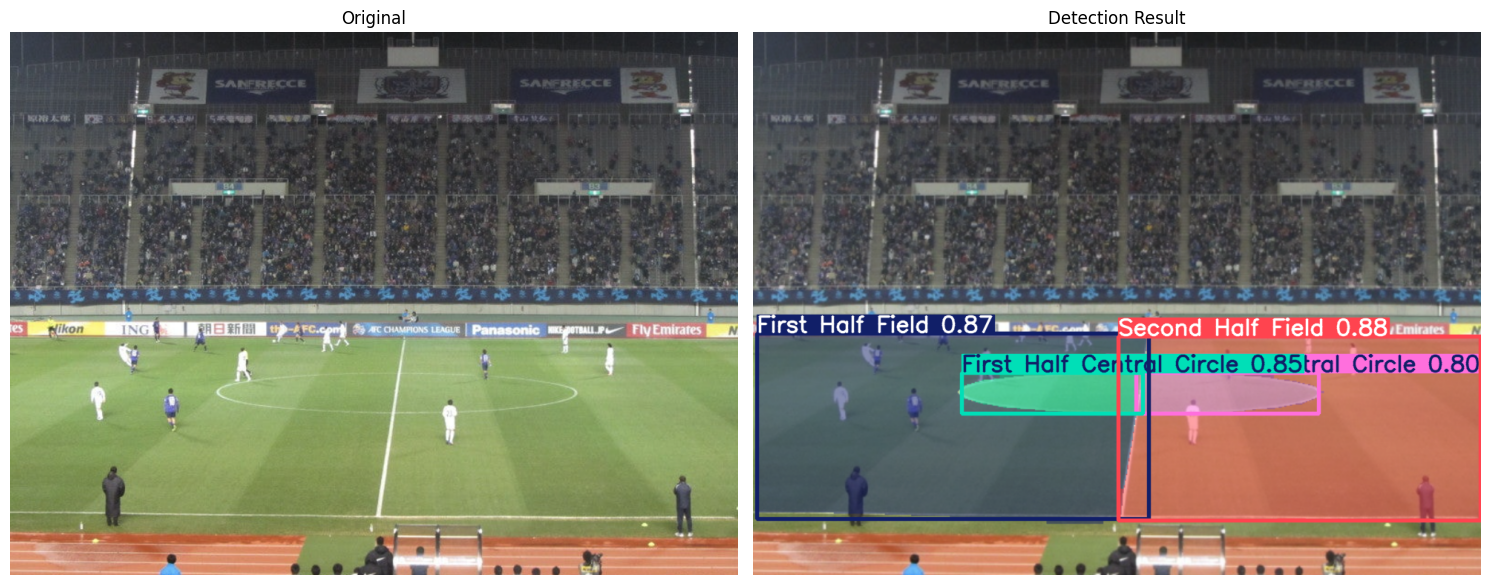

💾 結果を保存: result.jpg


In [12]:
def inference_jupyter(image_path, model_path=None):
    """Jupyter環境用の推論関数"""
    
    # モデルパスの自動検索
    if model_path is None:
        from pathlib import Path
        runs_dir = Path("runs/segment")
        if runs_dir.exists():
            # 最新のbest.ptを探す
            best_models = list(runs_dir.glob("learning_time_5h/weights/best.pt"))
            if best_models:
                model_path = str(max(best_models, key=lambda p: p.stat().st_mtime))
                print(f"🔍 自動検出: {model_path}")
            else:
                raise FileNotFoundError("学習済みモデルが見つかりません")
    
    # モデルロード
    print(f"📦 モデルをロード中...")
    model = YOLO(model_path)
    
    # 推論実行
    print(f"🖼️ 推論実行: {image_path}")
    results = model(image_path, conf=0.25)
    result = results[0]
    
    # 検出結果を表示
    if result.boxes is not None:
        print(f"✅ {len(result.boxes)}個のオブジェクトを検出")
        
        # クラスごとの集計
        class_counts = {}
        for box in result.boxes:
            class_name = model.names[int(box.cls)]
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
        
        for name, count in class_counts.items():
            print(f"   - {name}: {count}個")
    else:
        print("❌ 検出なし")
    
    # 結果を可視化
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    
    # 元画像
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[0].imshow(img_rgb)
    axes[0].set_title("Original")
    axes[0].axis('off')
    
    # アノテーション結果
    annotated = result.plot()
    axes[1].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    axes[1].set_title("Detection Result")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 結果を保存
    cv2.imwrite("result.jpg", annotated)
    print("💾 結果を保存: result.jpg")
    
    return results

# 使用例
results = inference_jupyter("sample1.png")

In [7]:
import ipywidgets as widgets
from IPython.display import display

def interactive_inference():
    """インタラクティブな推論UI"""
    
    # ウィジェット作成
    file_upload = widgets.FileUpload(
        accept='image/*',
        multiple=False,
        description='画像選択:'
    )
    
    conf_slider = widgets.FloatSlider(
        value=0.25,
        min=0.0,
        max=1.0,
        step=0.05,
        description='信頼度:',
        continuous_update=False
    )
    
    output = widgets.Output()
    
    def on_upload_change(change):
        """ファイルアップロード時の処理"""
        with output:
            output.clear_output()
            
            if file_upload.value:
                # アップロードされたファイルを取得
                uploaded = file_upload.value[0]
                
                # 一時ファイルとして保存
                with open('temp_upload.jpg', 'wb') as f:
                    f.write(uploaded['content'])
                
                # 推論実行
                results = inference_jupyter('temp_upload.jpg')
    
    # イベントハンドラを設定
    file_upload.observe(on_upload_change, names='value')
    conf_slider.observe(lambda x: on_upload_change(None), names='value')
    
    # UI表示
    display(widgets.VBox([file_upload, conf_slider, output]))

# 実行
interactive_inference()